# M5B 의사결정나무를 통한 고객분석 방법
- 의사결정나무 모델 개념
- 고객행동 예측에 의사결정나무 기법을 사용하는 방법
<br><br>
- [목표] 가장 기본적인 머신러닝 기법의 실전적 활용방안 이해

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt5(arr):
    stdev = .07*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


import warnings
warnings.filterwarnings('ignore')


# local data path
dataPath = 'D:/YONG/myPydata/' # 데이터 위치는 사용자 지정

import matplotlib.font_manager

    
# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


## 데이터 불러오기

In [2]:
# 상품 테이블 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)


# 판매내역 테이블 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)


# 고객 테이블 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)


### 주제1: 의사결정나무를 사용한 매출변화 분석

[ 연습용 분석의 내용 ]
- 2년 기간 중 매출금액이 큰 시기와 작은 시기를 구별하는 의사결정나무 모형 생성
- 즉, 어떤 특성을 가진 기간에 매출이 많은가?

In [3]:
# 월별 매출액 집계 ~ 2019~2020 2개년간 월별 집계

sales01 = sales[['date','amt']]
sales01['saleMon'] = sales01.date.str.slice(0,7)
display(sales01.sort_values('date').head())
display(sales01.sort_values('date').tail())

sales02 = sales01[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()
display(sales02.tail())

,date,amt,saleMon
69,2019-01-01 08:29:29.039055,100000,2019-01
50,2019-01-01 10:16:11.349410,185000,2019-01
57,2019-01-01 11:38:32.175671,145000,2019-01
26,2019-01-01 11:49:09.361595,60000,2019-01
2,2019-01-01 11:53:27.316416,70000,2019-01


,date,amt,saleMon
30446,2020-12-30 21:51:44.797043,70000,2020-12
41905,2020-12-30 21:56:25.910273,140000,2020-12
41921,2020-12-30 22:25:51.786426,145000,2020-12
37053,2020-12-30 22:26:44.725806,100000,2020-12
41891,2020-12-30 22:40:11.831680,120000,2020-12


,saleMon,amt
19,2020-08,132261000
20,2020-09,222280000
21,2020-10,117480000
22,2020-11,256118000
23,2020-12,234235000


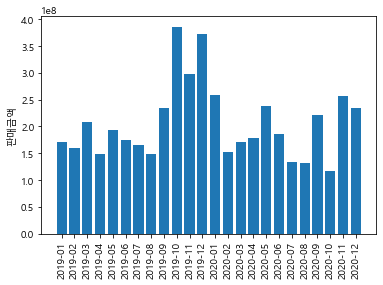

In [4]:
# 집계된 데이터 시각적 확인

plt.bar(sales02.saleMon, sales02.amt)
plt.xticks(rotation=90)
plt.ylabel('판매금액')
plt.show()

In [5]:
# 파이썬 sklearn에서의 의사결정나무 모형은 입력변수로 수치형의 변수만을 사용
# saleMon 월은 string (object) 문자형 data type인 변수

# 순서를 나타내는 수치형 변수 생성

sales02['mnthSeq'] = np.arange(len(sales02))
sales02.tail()

,saleMon,amt,mnthSeq
19,2020-08,132261000,19
20,2020-09,222280000,20
21,2020-10,117480000,21
22,2020-11,256118000,22
23,2020-12,234235000,23


In [6]:
# 데이터 테이블 dataframe의 컬럼들에 대한 데이터 형식 data type 확인

sales02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   saleMon  24 non-null     object
 1   amt      24 non-null     int64 
 2   mnthSeq  24 non-null     int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 608.0+ bytes


### 의사결정나무 모형 생성

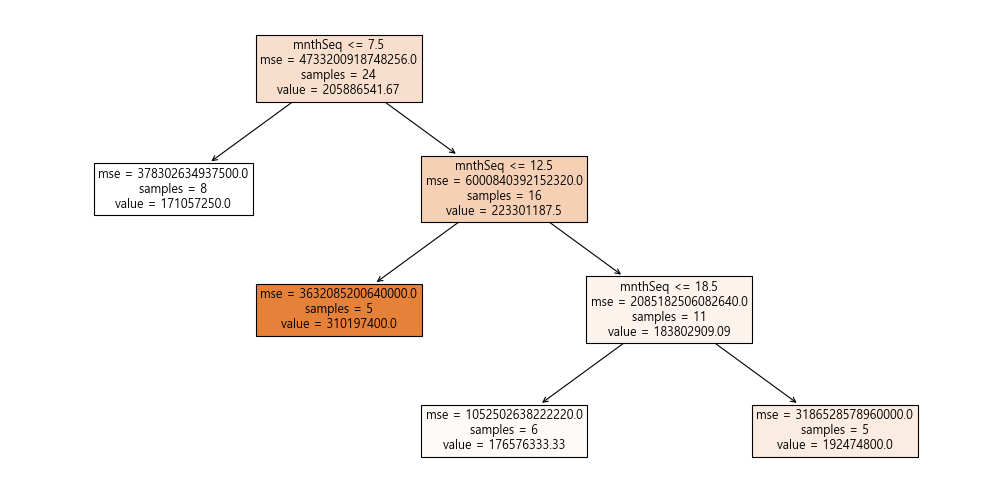

In [7]:
from sklearn.tree import DecisionTreeRegressor  # 의사결정나무 모듈 불러오기
from sklearn import tree # 의사결정나무 시각화 모듈 불러오기

# 모형의 옵션 지정
dt = DecisionTreeRegressor(min_samples_split=7, 
                           max_depth=3, 
                           min_samples_leaf=5)

# X 변수 지정 (saleMon 은 사용 불가 -- object 문자형 변수이며 중복이므로)
dtfeatures = ['mnthSeq']

# 모형에 데이터를 대입해 모형 완성
dt.fit(sales02[dtfeatures], sales02['amt'])


# 생성된 트리 모형의 시각화
plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, 
               feature_names=dtfeatures, 
               filled=True, 
               fontsize=11, 
               precision=2)
plt.show()

- mnthSeq (월의 순번) 가 7.5 보다 작거나 같으면 매출금액 amt 가 작음. 이 영역에 해당되는 월의 수는 8개
<br><br>
- 조건이 충족되면 오른쪽
- samples는 집단에 속하는 개체의 수
- value는 평균값
- 색상이 짙으면 value가 큰 것

- MSE Mean Squared Error 평균제곱오차 ?

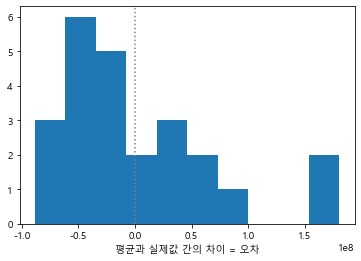

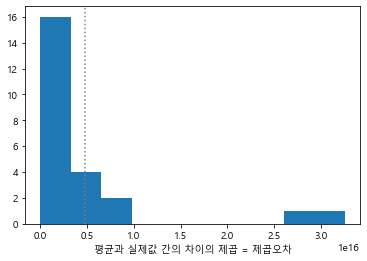

MSE =  4733200918748264.0


In [8]:
plt.hist(sales02.amt - sales02.amt.mean())
plt.xlabel('평균과 실제값 간의 차이 = 오차')
plt.axvline(0, color='grey', linestyle=":")
plt.show()

# 부호가 양과 음 양 방향 이므로 오차의 크기를 나타내기 어려움

SE = (sales02.amt - sales02.amt.mean())**2
plt.hist(SE)
plt.xlabel('평균과 실제값 간의 차이의 제곱 = 제곱오차')
plt.axvline(SE.mean(), color='grey', linestyle=":")
plt.show()

print('MSE = ', SE.mean())

- MSE 오차가 작다는 것은 한 집단내에서 차이가 크지 않다 즉, 비슷한 값을 가진 개체들로 구성된 집단이라는 의미
- 의사결정나무 decision tree는 전체 집단을 좀 더 집단 안에서 오차가 작은 비슷한 값의 개체 집단으로 구분해 가는 것

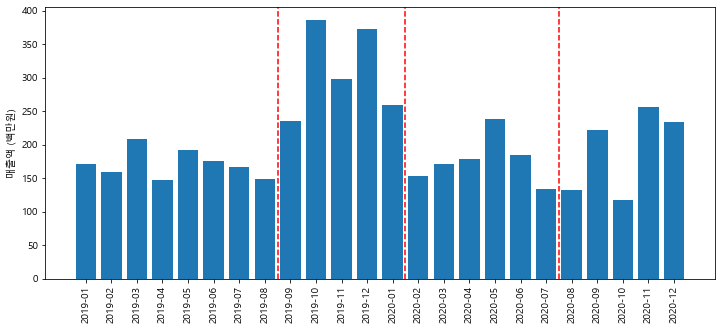

In [9]:
# 전체 매출 월별 추이와 의사결정나무로 찾아낸 변화지점 확인

plt.figure(figsize=(12,5))

# 백만원 단위로 변경 (나누기 사용)
plt.bar(sales02.saleMon, sales02.amt/1000000) 
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)

# 트리에서 찾아낸 변곡점(분기점)을 챠트에 표시
plt.axvline(7.5,color='red', linestyle='--') # 2019-09 부터
plt.axvline(12.5,color='red', linestyle='--') # 2020-01 까지
plt.axvline(18.5,color='red', linestyle='--')
plt.show()

# 트리의 최종 노드 갯수 (leaf nodes) 와 같은 4개 집단으로 구분 (3개 구분점 활용)

- 시간의 흐름에 따라 변화가 나타나는 것 처럼 보이지만 세부적으로는 **직선의 관계(추세)**와 동시에 **계절적인 차이** 패턴도 존재하는 듯

## 의사결정나무 기본개념

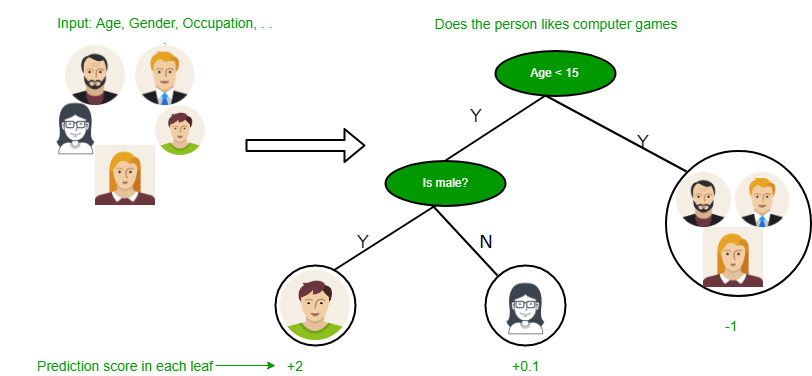

- 한 변수 값의 변화에 따라 다른 변수 값이 어떻게 달라지는 관계가 있는가를 나타내는 모델
- 독립변수(size: X)와 종속변수(price: Y)간의 관계를 영역별 값의 관계로 파악
<br><br>
- 종속변수가 무엇인가에 따라 **classification**(유형의 분류) 과 **regression** (수치값의 추측) 두 가지로 구분됨
<br><br>
- 원래 의사결정나무에 문자형(category, object)인 독립변수만 사용가능한 것은 아님 (sklearn에서 수치만 허용할 뿐)

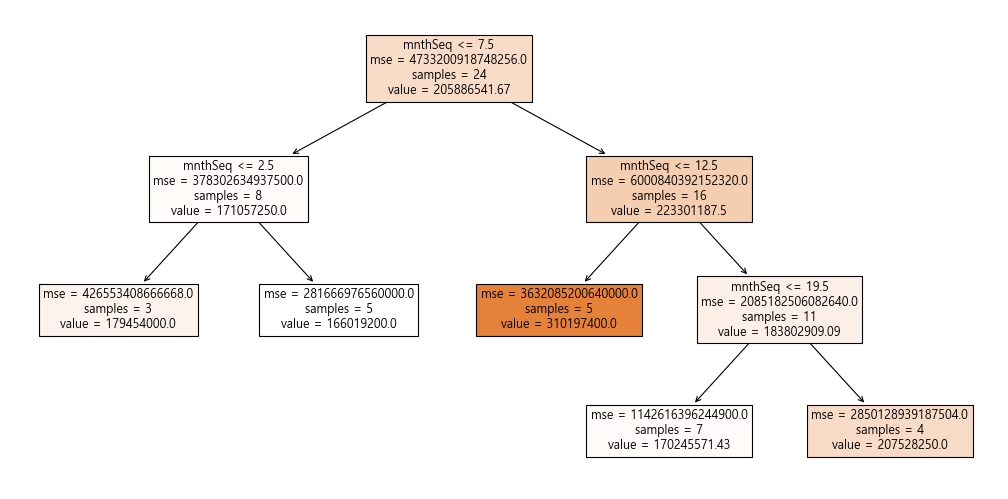

In [10]:
from sklearn.tree import DecisionTreeRegressor  # 의사결정나무 모듈 불러오기
from sklearn import tree # 의사결정나무 시각화 모듈 불러오기

# 모형의 옵션 지정
dt = DecisionTreeRegressor(min_samples_split=6, # 분기 기준 변경
                           max_depth=3, 
                           min_samples_leaf=3)  # 최소 3개 값은 존재해야 노드로 생성

# X 변수 지정
dtfeatures = ['mnthSeq']

# 모형에 데이터를 대입해 모형 완성
dt.fit(sales02[dtfeatures], sales02['amt'])


# 생성된 트리 모형의 시각화
plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, 
               feature_names=dtfeatures, 
               filled=True, 
               fontsize=11, 
               precision=2)
plt.show()

- 분기옵션의 변경으로 인해 [7.5, 12.5,18.5] 에서 분기점이 [2.5,7.5,12.5,19.5] 일부 변경됨
<br><br>
- 트리모형은 **분기와 분기 split 의 정지 stopping** 에 대해 설정한 **옵션**에 따라 결과가 상당히 달라질 수 있음

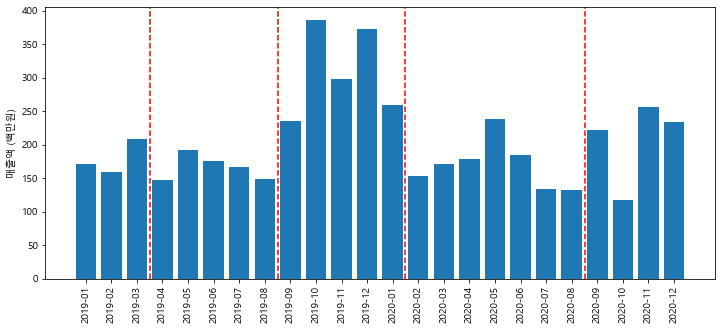

In [11]:
# 전체 매출 월별 추이와 의사결정나무로 찾아낸 변화지점 확인

plt.figure(figsize=(12,5))

# 백만원 단위로 변경 (나누기 사용)
plt.bar(sales02.saleMon, sales02.amt/1000000) 
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)
# 트리에서 찾아낸 변곡점(분기점)을 챠트에 표시
plt.axvline(2.5,color='red', linestyle='--') # 2019-04 부터
plt.axvline(7.5,color='red', linestyle='--') # 2019-09 부터
plt.axvline(12.5,color='red', linestyle='--') # 2020-02 부터
plt.axvline(19.5,color='red', linestyle='--') # 2020-09 부터
plt.show()

# 변경된 트리의 최종 노드 갯수 (leaf nodes) 와 같은 5개 집단으로 구분 (4개 구분점 활용)

- 트리 생성 결과는 옵션의 변경에 상당히 영향을 받으므로 다양한 옵션 테스트 후 최종 옵션 결정 필요
- 단, 실전 상황에서 **최적의 옵션을 찾기위해 한없이 시간을 보내는 것은 부적절**
- 서너번 정도 (상세하게 Vs. 대략적으로) 옵션을 바꿔 테스트해 보고 빠르게 결정 필요

## 주제2 : 고객 속성을 추측하는 모델 생성 예제

In [12]:
# 2019년 거래가 있었던 고객만 추출
tgt_custs = sales[sales.date.str.slice(0,10)<'2020-01-01'].cust_id.unique()

# 고객 테이블에서 해당 고객의 기본 정보 추출 (geodemographics)
cust_prfl = custmast[custmast.cust_id.isin(tgt_custs)][['cust_id', 'sex', 'area', 'age']]
cust_prfl.sample(5)

,cust_id,sex,area,age
3099,B100007163,F,seoul,40
8540,B100033932,F,seoul,32
18172,B100096511,F,inchon,56
3436,B100092583,M,inchon,32
13288,B100084306,F,gyunggi,35


In [13]:
cust_prfl.shape # 해당 고객 sample 수 확인

(8795, 4)

- 고객의 행동을 분석하기 위해서는 행동을 수치로 계산하기 위한 대상 기간 설정 필요
- 예: 분석기준 시점 최근 1년간을 기간으로 설정하고 분석

In [14]:
# 카테고리 형식의 변수를 그래도 사용할 수 없기에 지역을 서울 여부로 변경
# 성별은 여성 여부로 변경

cust_prfl['is_seoul'] = np.where(cust_prfl.area=='seoul',1,0)
cust_prfl['is_female'] = np.where(cust_prfl.sex=='F',1,0)
cust_prfl.sample(5)

,cust_id,sex,area,age,is_seoul,is_female
1502,B100096315,F,gyunggi,29,0,1
23366,B100031093,F,seoul,22,1,1
1347,B100051118,M,gyunggi,33,0,0
21182,B100075581,M,seoul,41,1,0
22491,B100083332,F,gyunggi,46,0,1


- 연습용 예제로 수치형 변수인 연령을 종속변수(Y)로 설정
- 성별, 지역을 독립변수 (X) 로 설정

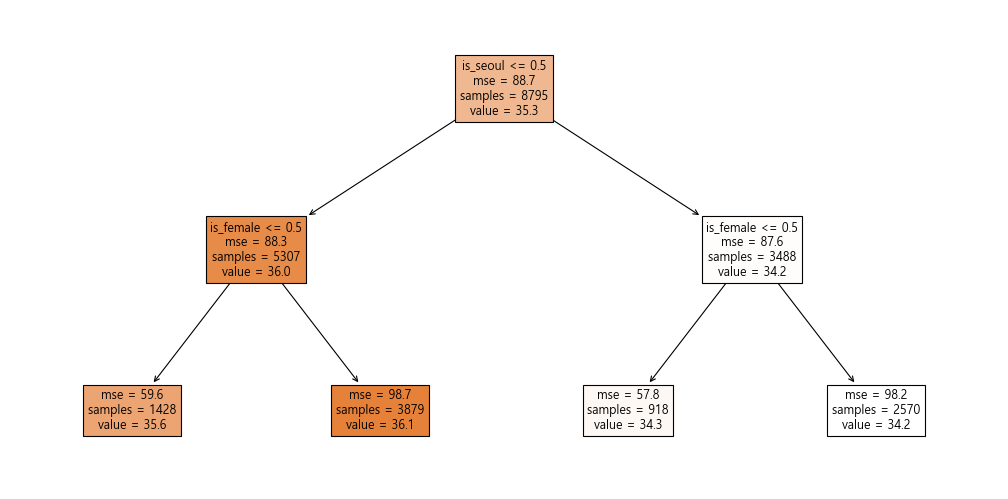

In [15]:
from sklearn.tree import DecisionTreeRegressor # Y가 수치형이므로 regression
from sklearn import tree

dt = DecisionTreeRegressor(min_samples_split=200,max_depth=3, min_samples_leaf=100)

# X 변수는 두 개 (즉, 복수)
dtfeatures = ['is_female', 'is_seoul']
dt.fit(cust_prfl[dtfeatures], cust_prfl['age'])

# 트리를 그림으로 나타내기
plt.figure(figsize=(16,8), dpi=80) # 트리 해상도 높이기 위해 dpi 지정
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True,  # 채우기 색으로 Y 값이 value 크기 차이 시각적으로 쉽게 인지 가능하게 표시
               fontsize=11, 
               precision=1) # precision 소수점 자리수 지정
plt.show()

- 왼쪽부터 True, False 순서
- 맨 위(root) 노드에서 서울 값이 0.5보다 작거나 같으면 (==서울여부 값이 0 이면 즉, 서울이 아니면) 왼쪽의 값 평균 36으로 상대적으로 연령 값 큼)
- 전체 고객의 평균 연령은 35.3세
- 서울아닌 지역(is_seoul==0)의 여성 집단이 평균 연령 가장 높음. 36.1세
- 서울 지역의 여성(is_female==1) 집단이 평균연령 가장 낮음 34.1세 

,is_seoul,age
0,0,35.982099
1,1,34.214450


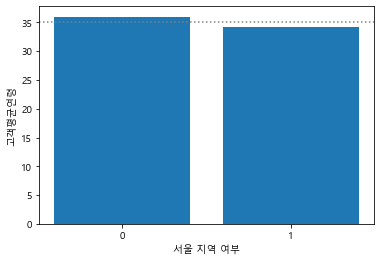

In [16]:
# 트리 모형 결과를 다른 형태로 표현해서 시각적으로 확인

custstat01 = cust_prfl[['is_seoul', 'age']].groupby('is_seoul').mean().reset_index()
display(custstat01)

# 막대챠트 생성
plt.bar(custstat01.is_seoul.astype(int).astype(str), custstat01.age)
plt.xlabel('서울 지역 여부')
plt.ylabel('고객평균연령')
plt.axhline(custstat01.age.mean(), color='grey', linestyle=':')
plt.show()

In [17]:
# 성별 지역별 평균연령 집계 테이블 생성
cust_prfls1 = cust_prfl.groupby(['is_seoul', 'is_female']).age.mean().reset_index()
display(cust_prfls1)

# 교차표 형태로 변형 pivot 피봇
cust_prfls1.pivot(index='is_seoul', columns='is_female', values='age')

,is_seoul,is_female,age
0,0,0,35.572829
1,0,1,36.132766
2,1,0,34.290850
3,1,1,34.187160


is_female,0,1
is_seoul,,
0,35.572829,36.132766
1,34.290850,34.187160


In [18]:
# 교차표 행렬 바꿈
cust_prfls1.pivot(index='is_seoul', columns='is_female', values='age').T # .T 는 transpose

is_seoul,0,1
is_female,,
0,35.572829,34.29085
1,36.132766,34.18716


<AxesSubplot:xlabel='is_seoul'>

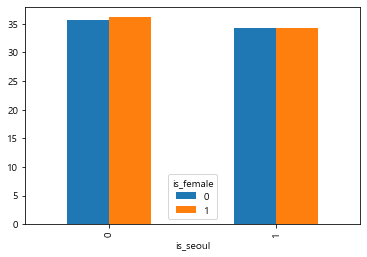

In [19]:
# pivot 한 테이블을 바로 시각화
cust_prfls1.pivot(index='is_seoul', columns='is_female', values='age').plot(kind='bar')

# 서울에서는 성별에 따라 연령 차이 거의 없으나
# 기타 지역에서는 여성이 연령이 좀 더 많음

- [ SELF 연습문제 ]  성별에 따른 고객평균연령을 막대챠트로 시각화하라

## 주제 3: 구매금액 특성 분석에 의사결정나무 활용

In [20]:
# 고객별 구매금액에 다른 변수들이 어떤 영향을 주는지를 트리 모형으로 분석
# Regression 형태의 문제

# 2019년 고객별 구매금액 집계
# 먼저 2019년 판매건만 추출한 후 
# 고객별로 금액 합계를 집계
dfssum1 = sales[sales.date.str.slice(0,4)=='2019'][['cust_id','amt']].groupby('cust_id').sum().reset_index()
dfssum1.head(5)

,cust_id,amt
0,B100000003,250000
1,B100000022,35000
2,B100000043,60000
3,B100000055,110000
4,B100000070,100000


In [21]:
# 2019년 구매금액과 앞서 생성한 고객기본정보 테이블을 결합

cust_prfl1 = cust_prfl.merge(dfssum1, how='left', on='cust_id')
cust_prfl1.sample(5)

# 연령, 여성여부, 서울지역여부 세 가지 독립변수들이 종합적으로 2019년 금액과 어떤 관계를 가지는지 분석

,cust_id,sex,area,age,is_seoul,is_female,amt
3798,B100045705,F,gangwon,40,0,1,185000
3228,B100042548,M,gyunggi,37,0,0,100000
1258,B100033962,F,seoul,34,1,1,65000
7939,B100032202,F,inchon,26,0,1,120000
4358,B100074815,F,gyunggi,29,0,1,250000


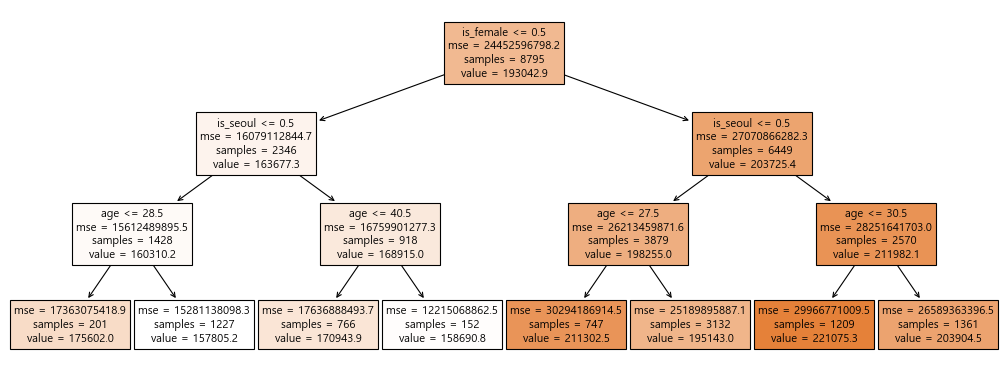

In [22]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=100)

# 세 개의 X 변수
dtfeatures = ['is_female','is_seoul','age']
dt.fit(cust_prfl1[dtfeatures], cust_prfl1['amt'])

# sklearn decision trees do not handle categorical data

plt.figure(figsize=(16,6), dpi=80)
# 일차 출력된 트리 모습을 보고 해상도 좌우비율(장평), 폰트크기 등 조절 가능
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=10, precision=1)
plt.show()

- 여성 & 서울 & 젊은 고객들의 2019 구매금액이 가장 컸음

In [23]:
# 상관관계 확인해 보기

cust_prfl1[['is_female', 'is_seoul','age','amt']].corr()

,is_female,is_seoul,age,amt
is_female,1.000000,0.006516,0.013439,0.113264
is_seoul,0.006516,1.000000,-0.091798,0.039425
age,0.013439,-0.091798,1.000000,-0.019393
amt,0.113264,0.039425,-0.019393,1.000000


- 모두 수치형 변수이므로 상관관계 확인은 가능
- 단 직선이 아닌 관계가 존재한다면 상관관계로 설명되지 않을 것

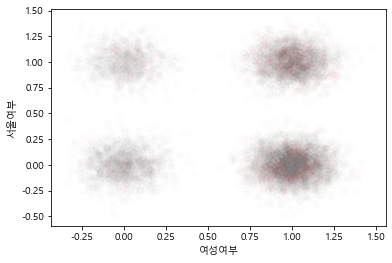

In [24]:
# scatter plot을 활용한 시각화
colors1 = np.where(cust_prfl1.amt>cust_prfl1.amt.quantile(0.9),'red','grey')
plt.scatter(rjitt5(rjitt5(cust_prfl1.is_female)), rjitt5(rjitt5(cust_prfl1.is_seoul)),
            color=colors1, alpha=0.01)
plt.xlabel('여성여부')
plt.ylabel('서울여부')
plt.show()

- 여성 특히 서울 여성, 젊은 서울 여성의 구매액이 큼

In [25]:
# 교차표 crosstab 활용 (pandas)
# 집단별 인원수 확인

pd.crosstab(cust_prfl1.is_female, cust_prfl1.is_seoul, dropna=False)

is_seoul,0,1
is_female,,
0,1428,918
1,3879,2570


Text(0, 0.5, '고객수')

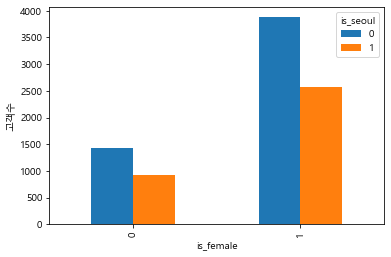

In [26]:
# 교차표의 시각화

pd.crosstab(cust_prfl1.is_female, cust_prfl1.is_seoul, dropna=False).plot(kind='bar')
plt.ylabel('고객수')

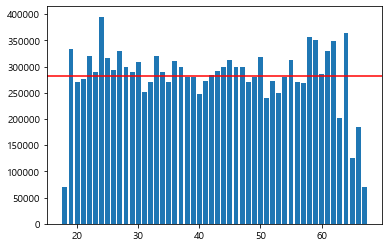

In [27]:
# 연령별 구매금액 차이 분석

# 상위 20%에 해당하는 값을 집계해 비교
cust_prfl3 = cust_prfl1[['age', 'amt']].groupby('age').quantile(0.8).reset_index()


plt.bar(cust_prfl3.age, cust_prfl3.amt)
plt.axhline(cust_prfl3.amt.mean(), color='red')
plt.show()

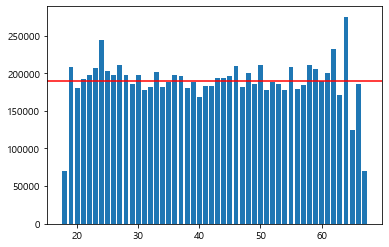

In [28]:
# 연령별 구매금액 차이 분석

# 연령별 평균 값을 집계해 비교
cust_prfl3 = cust_prfl1[['age', 'amt']].groupby('age').mean().reset_index()

plt.bar(cust_prfl3.age, cust_prfl3.amt)
plt.axhline(cust_prfl3.amt.mean(), color='red')
plt.show()

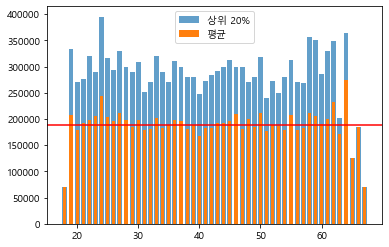

In [29]:
# 평균과 상위 20% 값을 함께 보기

cust_prfl3 = cust_prfl1[['age', 'amt']].groupby('age').quantile(0.8).reset_index()
# 상위 20%에 해당하는 값을 집계해 비교

cust_prfl31 = cust_prfl1[['age', 'amt']].groupby('age').mean().reset_index()
# 연령별 평균 값을 집계해 비교


plt.bar(cust_prfl3.age, cust_prfl3.amt, alpha=0.7)
plt.bar(cust_prfl31.age, cust_prfl31.amt, width=0.5)
plt.legend(['상위 20%', '평균'])
plt.axhline(cust_prfl31.amt.mean(), color='red')
plt.show()

- 시각적으로는 평균보다 상위20%값 지표가 좀 더 연령별 차이(편차)가 큰 것 처럼 보임

In [30]:
# 표준편차를 평균으로 나눠서 CV를 구해 변동성의 크기를 확인

# CV는 척도 scale의 차이에 따라 표준편차가 차이나는 것을 조절하려는 장치

cust_prfl3.amt.std()/cust_prfl3.amt.mean(), cust_prfl31.amt.std()/cust_prfl31.amt.mean()

(0.2206584207516619, 0.17019554048541732)

- CV가 더 큰 평균값 추이가 상위20% 값의 추이에 비해 실제로는 오히려 더 큰 편차 **(착시현상?)**

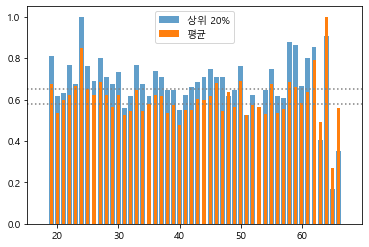

In [31]:
# 평균과 상위 20% 값을 함께 보기

plt.bar(cust_prfl3.age, mnmx_scl(cust_prfl3.amt), alpha=0.7)
plt.bar(cust_prfl31.age, mnmx_scl(cust_prfl31.amt), width=0.5)
plt.legend(['상위 20%', '평균'])
plt.axhline(mnmx_scl(cust_prfl3.amt).mean(), color='grey', linestyle=':')
plt.axhline(mnmx_scl(cust_prfl31.amt).mean(), color='grey', linestyle=':')
plt.show()

### 고객별 2020년 값을 추정하는 예제 (미래 예측)

In [32]:
# 예측 모형은 과거기간에서 X를 미래기간에서 Y를 생성한 후 
# X와 Y간의 관계를 파악한 것
# 즉, Y = f(X)  미래 = 함수(과거)
# "미래는 과거에 어떤 변환을 거친 것이다"

In [33]:
# 2020년 고객별 금액 생성 (예측할 미래기간의 고객행동 즉, Y)

dfssum2 = sales[sales.date.str.slice(0,4)=='2020'][['cust_id','amt']].groupby('cust_id').sum().reset_index()
dfssum2.columns = ['cust_id', 'amt2020']
dfssum2.head(5)

,cust_id,amt2020
0,B100000005,200000
1,B100000023,225000
2,B100000037,140000
3,B100000038,70000
4,B100000043,70000


In [34]:
# 2020년 금액 추가

cust_prfl5 = cust_prfl1.merge(dfssum2, how='left', on='cust_id')
# 2019년에는 구매가 있었더라도 2020년에는 구매가 없는 고객들 (금액 0) 존재 가능
display(cust_prfl5.sample(5))

# 금액이 없으면 (NaN 이면) 0으로 대체 채워 넣음
cust_prfl5.fillna(0, inplace=True)
cust_prfl5.sample(5)

,cust_id,sex,area,age,is_seoul,is_female,amt,amt2020
5358,B100011255,F,gyunggi,32,0,1,215000,NaN
4538,B100016743,M,inchon,55,0,0,120000,NaN
6874,B100078638,F,gangwon,31,0,1,70000,115000.0
3820,B100060435,F,inchon,26,0,1,435000,NaN
1701,B100045559,F,seoul,33,1,1,400000,360000.0


,cust_id,sex,area,age,is_seoul,is_female,amt,amt2020
6112,B100038644,M,seoul,28,1,0,70000,0.0
2693,B100090964,F,gangwon,41,0,1,70000,0.0
3427,B100081051,F,gyunggi,28,0,1,65000,95000.0
5821,B100054551,M,seoul,38,1,0,70000,0.0
4193,B100092806,F,gyunggi,35,0,1,340000,0.0


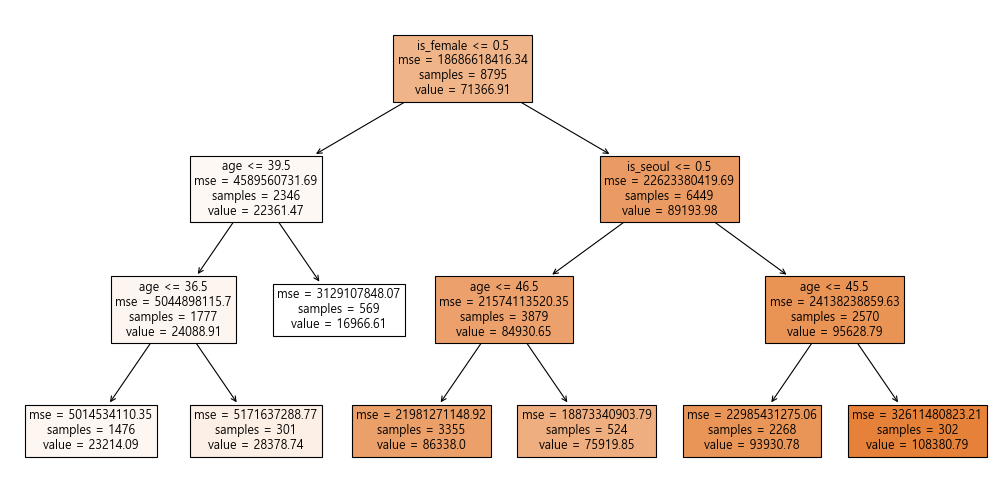

In [35]:
# 기본정보만을 활용해 2020년 구매금액 특성 분석

from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=300)

dtfeatures = ['is_female', 'is_seoul','age']
dt.fit(cust_prfl5[dtfeatures], cust_prfl5['amt2020'])


plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=11, precision=2)
plt.show()

- 트리는 어떤 의미를 전달하고 있는가? (트리가 보여주는 것을 **말로 풀어 본다면?**)

### 2019년도의 패턴과 2020 패턴은 어떻게 다른가?

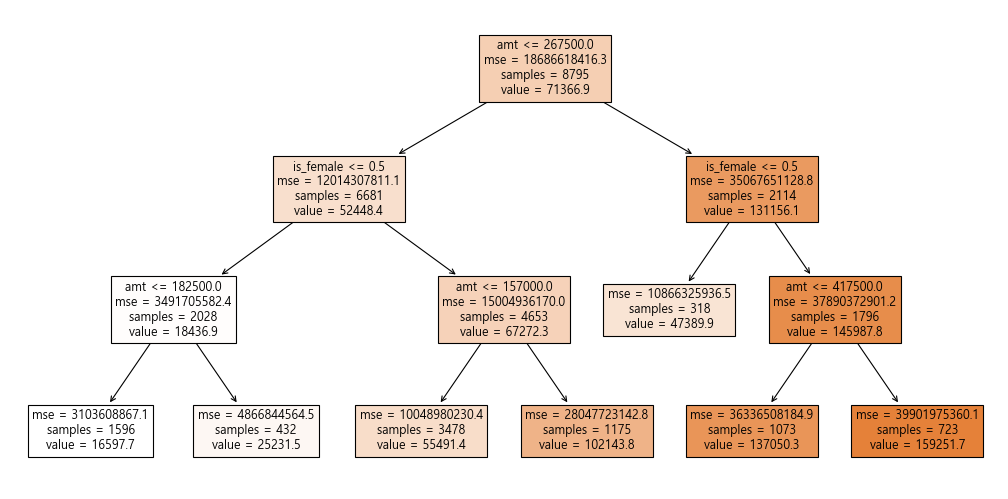

In [36]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=300)

# 2019년 구매금액을 독립변수 (변수) 리스트 에 추가
dtfeatures = ['is_female', 'is_seoul','age','amt']
dt.fit(cust_prfl5[dtfeatures], cust_prfl5['amt2020'])


plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=11, precision=1)
plt.show()

- 2019 금액이 컸던 고객들이 2020에도 금액이 큼
- 다른 기본정보 보다 가장 중요한 항목

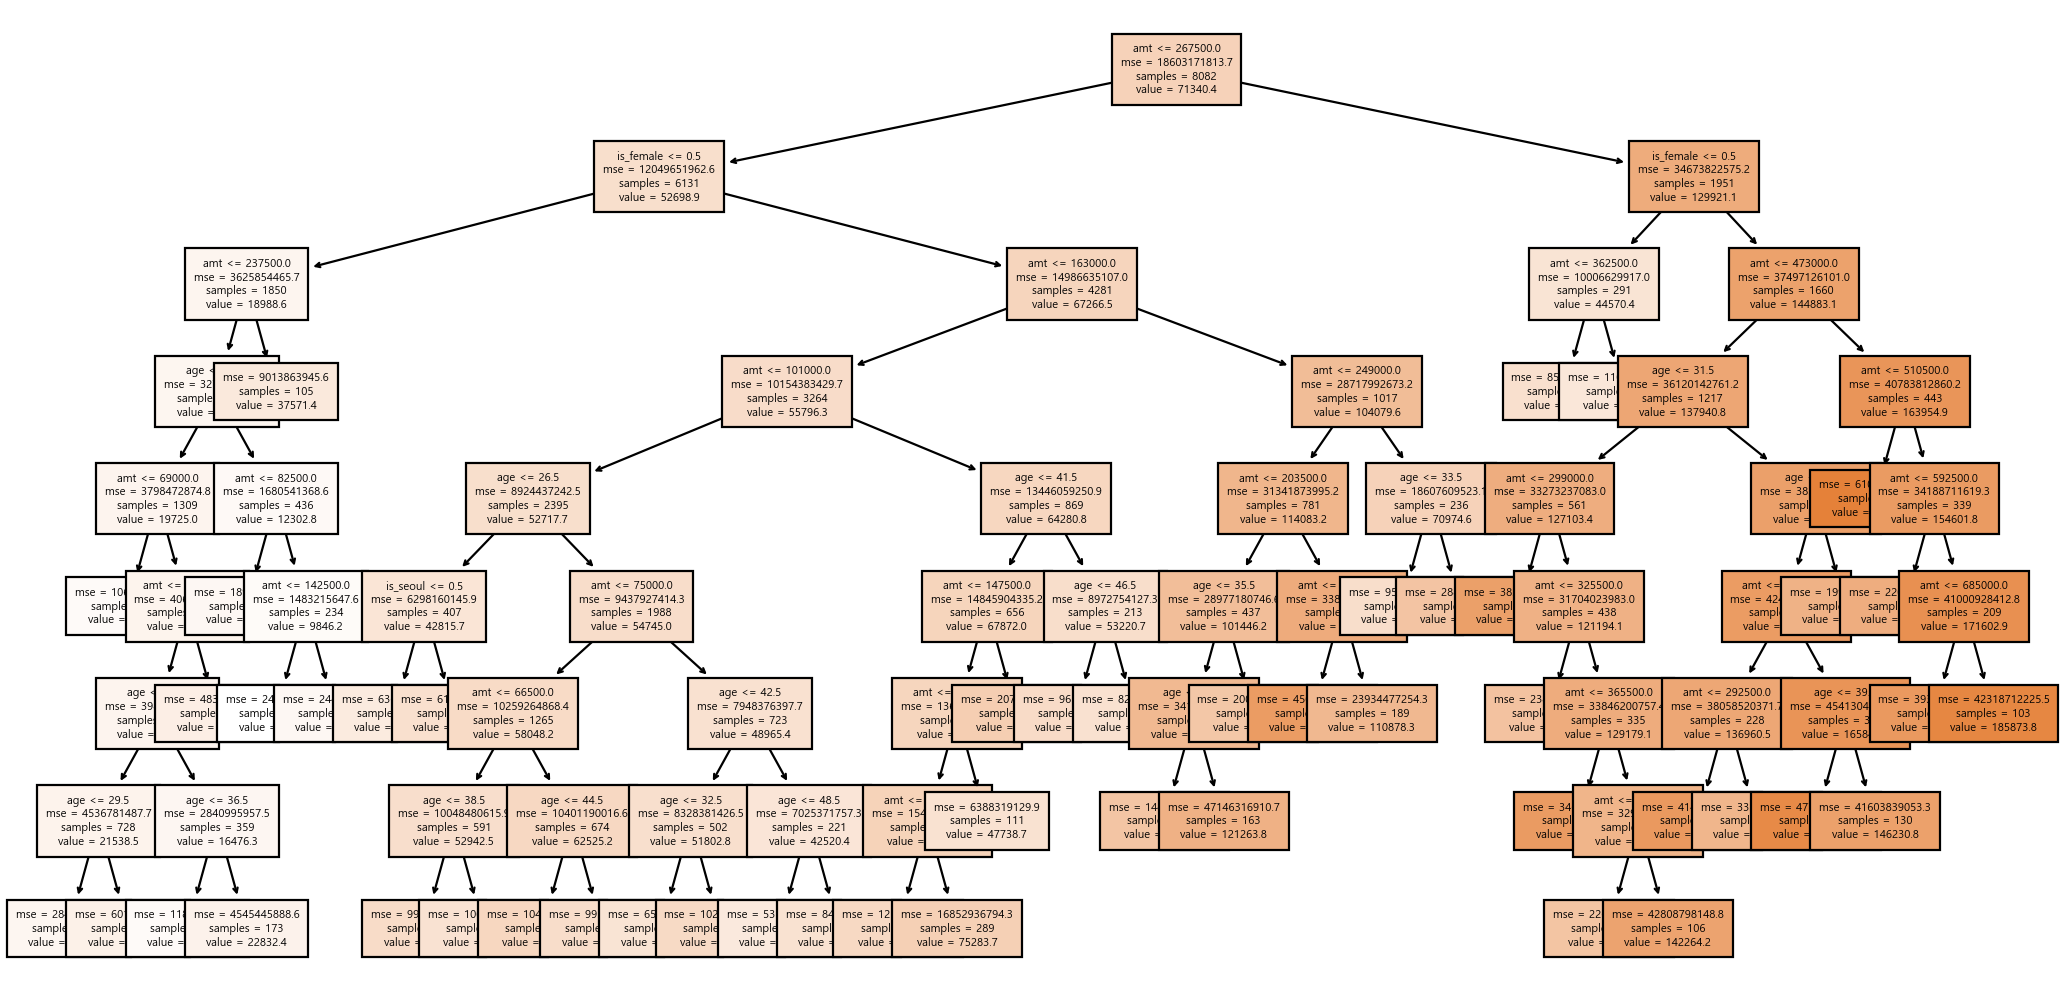

In [61]:
# 울창하고 정밀한 트리를 그려본다면?

from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=100)

# 2019년 구매금액을 독립변수 (변수) 에 추가
dtfeatures = ['is_female', 'is_seoul','age','amt']
dt.fit(cust_prfl5[dtfeatures], cust_prfl5['amt2020'])


plt.figure(figsize=(16,8), dpi=160)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=5, precision=1)
plt.show()

,cust_id,sex,area,age,is_seoul,is_female,amt,amt2020,ratio_series
7266,B100003085,M,seoul,31,1,0,60000,0.0,0.000000
7783,B100012415,M,gyunggi,37,0,0,250000,140000.0,0.186667
2854,B100074869,F,seoul,35,1,1,180000,0.0,0.000000
7789,B100020900,F,seoul,29,1,1,90000,0.0,0.000000
7538,B100023346,M,gyunggi,28,0,0,80000,0.0,0.000000
3295,B100034661,F,inchon,29,0,1,500000,70000.0,0.046667
7963,B100085977,F,seoul,37,1,1,90000,240000.0,0.888889
4254,B100049939,F,seoul,25,1,1,500000,0.0,0.000000
8693,B100039341,F,gyunggi,48,0,1,90000,60000.0,0.222222
2510,B100099791,M,gyunggi,31,0,0,180000,0.0,0.000000


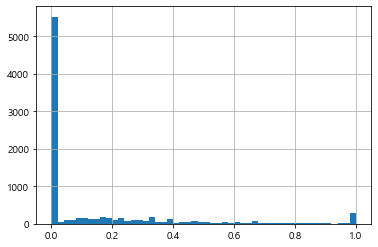

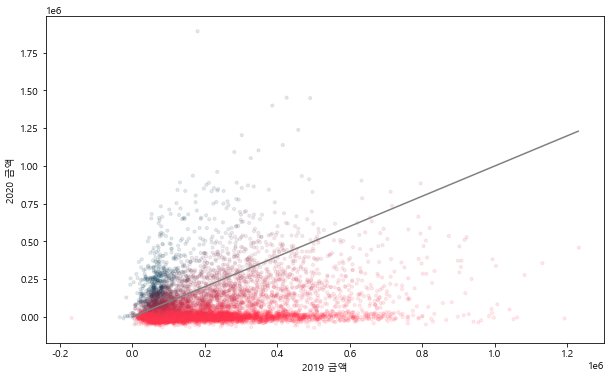

In [38]:
# 2019와 2020 고객별 금액 변화 분포 파악

cust_prfl5['ratio_series'] = cust_prfl5.amt2020/cust_prfl5.amt # 비율 값
cust_prfl5['ratio_series'] = np.where(cust_prfl5['ratio_series']>3,3,cust_prfl5['ratio_series'])
cust_prfl5['ratio_series'] = mnmx_scl(cust_prfl5['ratio_series'])
display(cust_prfl5.sample(10))

cust_prfl5['ratio_series'].hist(bins=50)
plt.show()

colors1 = [[1-v,0.2,0.3] for v in cust_prfl5['ratio_series']]
plt.figure(figsize=(10,6))
plt.scatter(rjitt(cust_prfl5['amt']), rjitt(cust_prfl5['amt2020']), 
            alpha=0.1, color=colors1, s=10)

# 2019년과 2020년 금액이 동일한 선 추가
# 이 선보다 위 쪽에 있는 고객은 금액이 증가한 것
plt.plot([0,cust_prfl5['amt'].max()], [0,cust_prfl5['amt'].max()], color='grey')
plt.xlabel('2019 금액')
plt.ylabel('2020 금액')
plt.show()

- 대각선의 아래쪽에 점이 많다는 것의 의미는?
- 2020년 매출이 전년에 비해 감소했다는 것?

In [39]:
# 분석 테이블에 값이 없는 빈 셀이 있는가? 확인 

cust_prfl5.isna().sum()

cust_id          0
sex              0
area             0
age              0
is_seoul         0
is_female        0
amt              0
amt2020          0
ratio_series    16
dtype: int64

In [40]:
# amt와 amt2020 모두 0이면 0/0 = 계산못함 = NaN

cust_prfl5[cust_prfl5.ratio_series.isna()]

# 추가로 분석에서 제외해야할 고객

,cust_id,sex,area,age,is_seoul,is_female,amt,amt2020,ratio_series
164,B100003937,F,seoul,22,1,1,0,0.0,NaN
1296,B100042039,M,gyunggi,53,0,0,0,0.0,NaN
1605,B100065951,F,inchon,44,0,1,0,0.0,NaN
1688,B100039198,F,seoul,40,1,1,0,0.0,NaN
2119,B100081470,F,gangwon,25,0,1,0,0.0,NaN
2471,B100046481,F,gyunggi,30,0,1,0,0.0,NaN
2906,B100009178,F,gyunggi,45,0,1,0,0.0,NaN
3009,B100049086,F,gyunggi,36,0,1,0,0.0,NaN
3605,B100051469,F,gyunggi,25,0,1,0,0.0,NaN
3726,B100032350,F,seoul,52,1,1,0,0.0,NaN


In [41]:
# 금액이 2019, 2020 각각이 모두 0인 특이한 경우 확인

# 고객리스트에 정상적으로 들어있는지 확인
display(custmast[custmast.cust_id=='B100003937'])

# 판매내역 확인
display(sales[sales.cust_id=='B100003937'])

,cust_id,sex,area,birthyr,hh_income,age,marital,ranseq,signup_date
481,B100003937,F,seoul,1999,26000,22,미혼,481,2017-07-23 11:11:27.243860


,ord_id,ord_dtid,store,item_id,qty,brand_nm,unit_prc,itemyr,season,scat,ranseq,lcat,size,color,item_id_detcode,amt,cust_id,datea,date
1503,300018987,1,Multi bupyong,SH1007204,1,Shoote,60000,2020,FW,바지,15,남성캐주얼,90,grey,104,60000,B100003937,2019-10-20,2019-10-20 11:39:12.554918
1504,300018987,2,Multi bupyong,SH1007204,-1,Shoote,60000,2020,FW,바지,15,남성캐주얼,90,grey,104,-60000,B100003937,2019-10-20,2019-10-20 11:39:12.554918


- 구매금액과 취소/반품 금액이 동일하면 거래이력은 있지만 (고객리스트에 포함) 집계값이 0 인 경우 발생

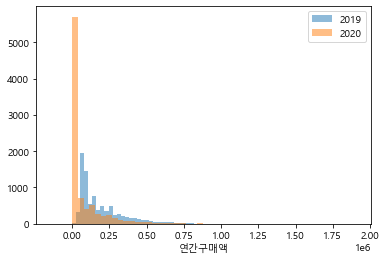

In [42]:
# 2019 금액과 2020 금액 분포의 비교

plt.hist(cust_prfl5.amt, bins=50, alpha=0.5)
plt.hist(cust_prfl5.amt2020, bins=50, alpha=0.5)
plt.legend([2019,2020])
plt.xlabel('연간구매액')
plt.show()

- 2019년에는 구매가 있었으나 2020년에는 구매가 없었던 고객들이 존재하기 때문에 분포에 큰 차이
- 2020년 구매하지 않은 고객들에서도 금액 감소 패턴 보임

### boxplot 활용한 시각화

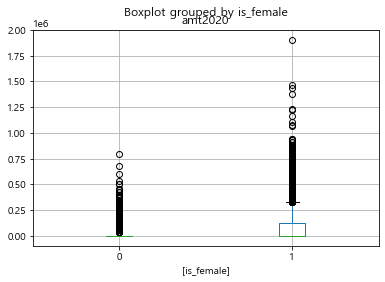

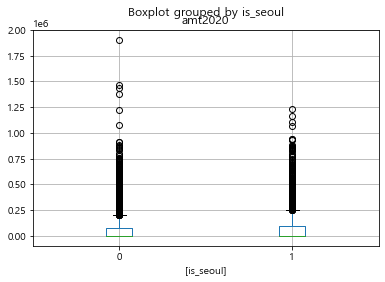

In [43]:
# boxplot을 활용한 시각적 분석 -- 집단간 비교

cust_prfl5[['is_female','amt2020']].boxplot(by='is_female')
plt.show()

cust_prfl5[['is_seoul','amt2020']].boxplot(by='is_seoul')
plt.show()

In [44]:
# 2019 구매가 있었던 집단으로 한정해서 분석

cust_prfl5 = cust_prfl5[cust_prfl5.amt>0]

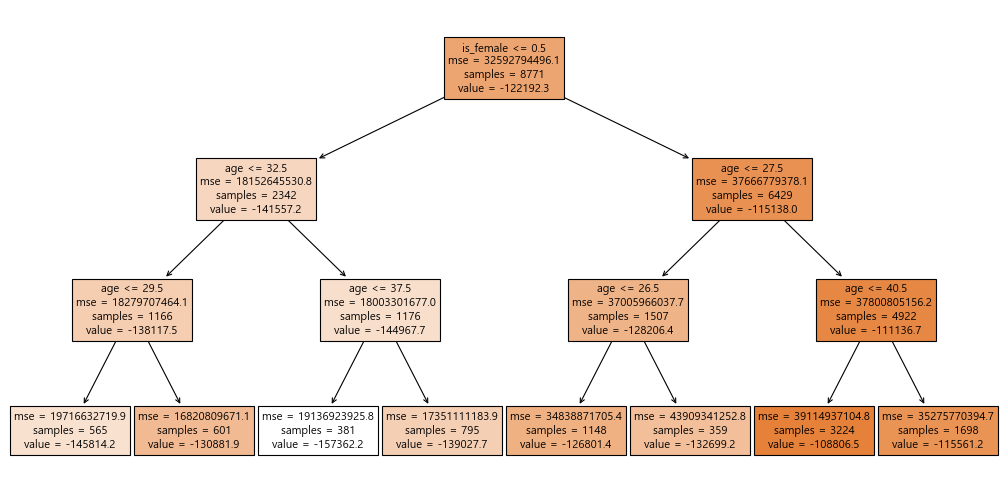

In [45]:
# 2020과 2019 금액의 차이 특징 파악

from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=300)

dtfeatures = ['is_female', 'is_seoul','age']

# 종속변수 Y를 금액의 차이로 설정
dt.fit(cust_prfl5[dtfeatures], cust_prfl5['amt2020']-cust_prfl5['amt'])


plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=10, precision=1)
plt.show()

- 대상도 동일하고 X가 모두 정확하게 같더라도 **Y를 다르게 지정하면 100% 다른** 모델
- 예: 2020년 10만원이상 구매가능성, 2020년 구매일수, 2020년 10만원이상 구매일수

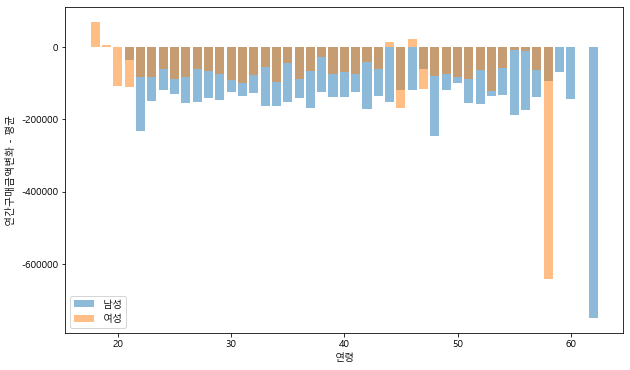

In [46]:
# 남성의 연령별 연간 구매금액 변화 구하기
cust_prfl51 = cust_prfl5[cust_prfl5.sex=='M'][['age','amt','amt2020']].groupby('age').mean().reset_index()
cust_prfl51['amtdiff'] = cust_prfl51.amt2020-cust_prfl51.amt

# 여성의 연령별 연간 구매금액 변화 구하기
cust_prfl52 = cust_prfl5[cust_prfl5.sex=='F'][['age','amt','amt2020']].groupby('age').mean().reset_index()
cust_prfl52['amtdiff'] = cust_prfl52.amt2020-cust_prfl51.amt

plt.figure(figsize=(10,6))
plt.bar(cust_prfl51.age,cust_prfl51.amtdiff, alpha=0.5)
plt.bar(cust_prfl52.age,cust_prfl52.amtdiff, alpha=0.5)
plt.legend(['남성','여성'])
plt.xlabel('연령')
plt.ylabel('연간구매금액변화 - 평균')
plt.show()

# CLASSIFICATION 분류 형태의 문제

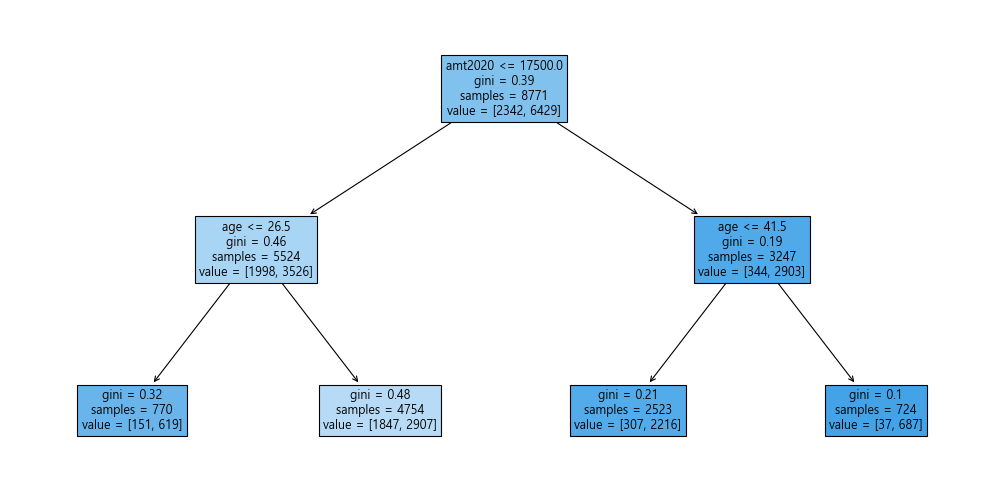

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=2, min_samples_leaf=100)

dtfeatures = ['amt2020', 'is_seoul','age']
# 성별을 분류하는 모델
dt.fit(cust_prfl5[dtfeatures], cust_prfl5['is_female'])


plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=11, precision=2)
plt.show()

- 모델의 결과 : 구매액이 많고 나이가 많으면 여성일 가능성 높다

## 주제 4 :  2020년에도 구매가 있는가를 분석 (고객이탈 예측)

In [48]:
# 단순집계를 통한 분석

# 2020년에 금액이 있었는지 flag 변수 추가
cust_prfl5['is_amt_2020'] = np.where(cust_prfl5['amt2020']>0,1,0)

# 2020년 금액여부에 따른 변수별 평균 산출
cust_prfl5[['amt', 'is_seoul','age','is_amt_2020']].groupby('is_amt_2020').mean().reset_index()

,is_amt_2020,amt,is_seoul,age
0,0,174315.532223,0.387038,35.383237
1,1,226372.959655,0.412997,35.083462


- 단순집계에서는 평균만 산출
- 단순집계에서는 변수별 scale 척도가 달라 비교 어려움
- 영향이 큰 변수가 무엇인지 파악 어려움

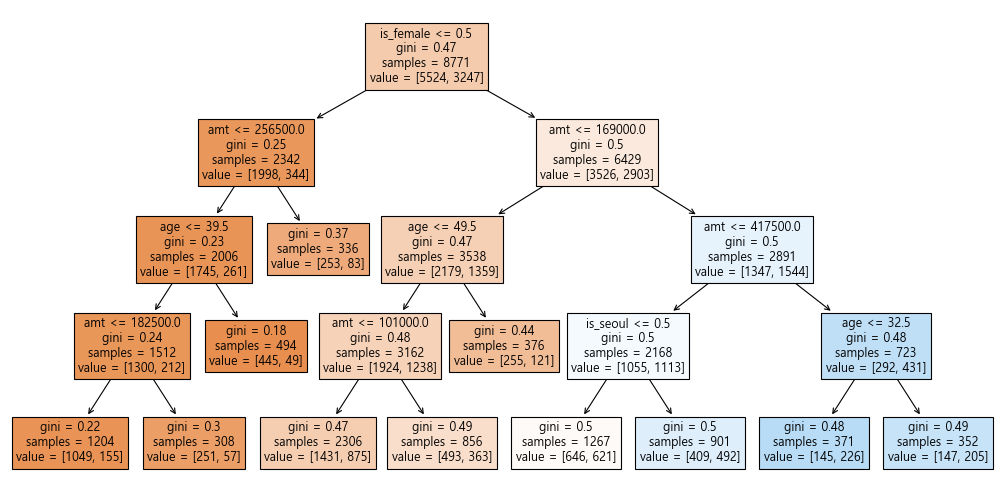

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=300)

dtfeatures = ['amt', 'is_seoul','age','is_female']
dt.fit(cust_prfl5[dtfeatures], cust_prfl5.is_amt_2020)


# visualize tree
plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, feature_names=dtfeatures, 
               filled=True, fontsize=11, precision=2)
plt.show()

### 가입기간 변수 추가

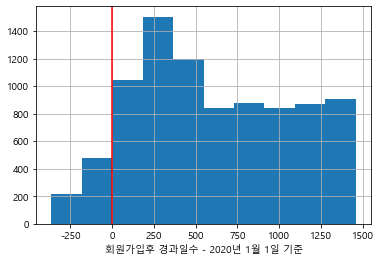

In [50]:
from datetime import datetime

date_time_str = '2020-01-01 00:00:00'
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

# 가입기간 signup_date 와 기준시점간의 차이가 가입기간
cust_prfl5['tenure'] = (date_time_obj - pd.to_datetime(custmast.signup_date.str.slice(0,10), format = '%Y-%m-%d')).dt.days
cust_prfl5['tenure'].hist()
plt.xlabel('회원가입후 경과일수 - 2020년 1월 1일 기준')
plt.axvline(0, color='red')
plt.show()

- 2019년말 기준 최근 1~2년 사이 회원 가입 많았음
- **[주의사항]** 기록 조차 삭제된 이탈고객들은 현재의 데이터에는 나타나지 않을 것

In [51]:
cust_prfl5[['tenure', 'amt', 'amt2020']].sample(10)

# 가입기간이 음의 값이라면 2020년 이후 회원가입한 것
# 이 경우 amt (2019년 구매금액) 값이 존재하면 오류 (회원가입일이 재가입으로 변경된 것?)

# 고객의 미래행동 분석에서는 가입이전에 구매한 건은 제외 필요
# 해당 고객을 분석에서 제외해야함

,tenure,amt,amt2020
959,126,120000,500000.0
2290,118,35000,0.0
1139,334,220000,160000.0
1755,767,395000,0.0
3139,1276,100000,0.0
7779,258,140000,645000.0
8192,392,160000,0.0
6968,854,200000,70000.0
8121,768,350000,0.0
4901,404,250000,0.0


In [52]:
# 가입이후 구매액만 존재하는 고객으로 분석 대상 조정

cust_prfl5 = cust_prfl5[cust_prfl5.tenure>=0]
cust_prfl5.shape

(8082, 11)

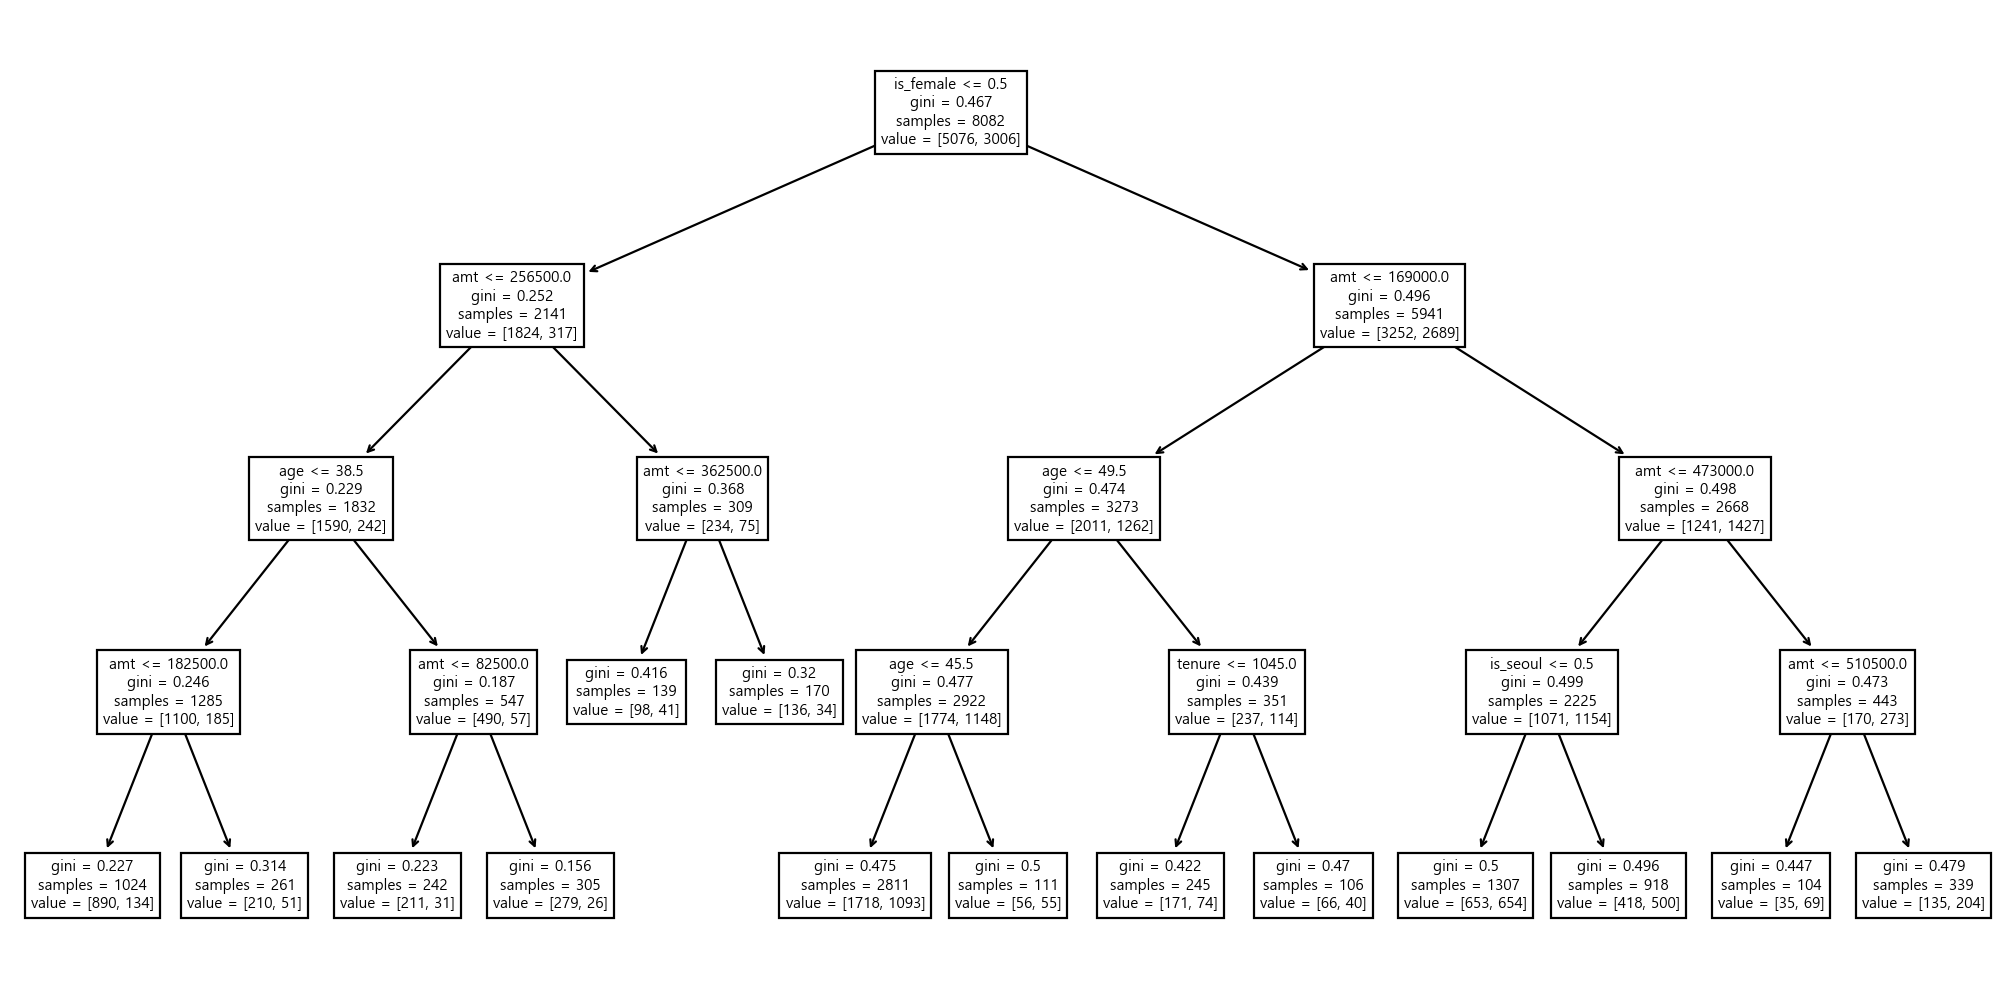

In [53]:
# 가입기간을 입력변수 (독립변수) 로 추가해 트리 생성

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

dtfeatures = ['amt', 'is_seoul','age','is_female','tenure']
dt.fit(cust_prfl5[dtfeatures], cust_prfl5.is_amt_2020)


# visualize tree
plt.figure(figsize=(16,8), dpi=160)
tree.plot_tree(dt, feature_names=dtfeatures) # 디폴트 옵션 사용시
plt.show()

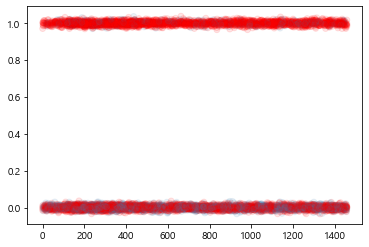

상관계수 0.0050810343350695805


In [54]:
# 회원가입기간이 영향이 있는가?
# 오랜 단골들은 2020년에도 활발했는가?

colors1 = np.where(cust_prfl5.is_female==1,'red','steelblue')
plt.scatter(cust_prfl5.tenure, rjitt(cust_prfl5.is_amt_2020),
           color=colors1, alpha=0.1)
plt.show()

# 상관관계 확인
print('상관계수', np.corrcoef(cust_prfl5.tenure, cust_prfl5.is_amt_2020)[0,1])

# 전체 집단에서 선형적으로는 관계가 나타나지 않음

# 일부 영역인 여성이며 금액 적고 연령이 많은 집단에서는 3년이상 기존 고객들의 이탈이 적은 패턴 나타남

- 2020년의 변화를 분석하기 위해서는 2020년에 새로 들어온 고객은 포함하지 않아야 함



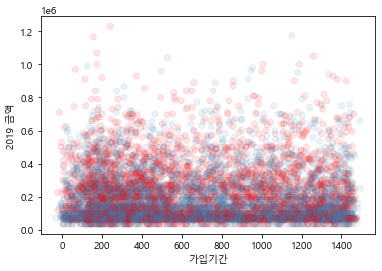

In [55]:
# 가입기간과 2019 금액 scatter plot

colors1 = np.where(cust_prfl5.amt2020>0,'red', 'steelblue')
plt.scatter(rjitt(cust_prfl5.tenure), cust_prfl5.amt, 
            alpha=0.1, color=colors1)
plt.xlabel('가입기간')
plt.ylabel('2019 금액')
plt.show()


In [56]:
# 입력변수간 상관관계 검토 

cust_prfl5[['amt', 'is_seoul','age','is_female','tenure','is_amt_2020']].corr().sort_values('is_amt_2020')

,amt,is_seoul,age,is_female,tenure,is_amt_2020
age,-0.018754,-0.087866,1.000000,0.011221,0.001235,-0.016369
tenure,0.003128,-0.004317,0.001235,0.003993,1.000000,0.005081
is_seoul,0.039803,1.000000,-0.087866,0.003611,-0.004317,0.022799
amt,1.000000,0.039803,-0.018754,0.113836,0.003128,0.160133
is_female,0.113836,0.003611,0.011221,1.000000,0.003993,0.278067
is_amt_2020,0.160133,0.022799,-0.016369,0.278067,0.005081,1.000000


- 여성이 금액이 크고, 서울거주가 많은 관계 나타남
- 서울이 아니고 여성, 2019 금액 클수록 가입기간이 긴 관계 존재
- 가입기간이 길수록 2020 금액 좀 더 많음 (매우 약한 관계)

### Classification에서의 프로파일링 - 집단 특성 비교표 작성

In [57]:
# target인 Y의 각 class별 주요 feature(predictor)와 추가적인 설명용 변수 값 비교

# 의미의 예: 2020년에 구매할 사람은 그렇지 않은 사람과 어떤 측면에서 차이가 있나?

cust_prfl5[['is_amt_2020', 'age', 'is_female', 'is_seoul', 'tenure','amt', 'amt2020']].groupby('is_amt_2020').mean().reset_index().T

,0,1
is_amt_2020,0.000000,1.000000
age,35.391647,35.071856
is_female,0.640662,0.894544
is_seoul,0.388101,0.411178
tenure,670.997242,675.425482
amt,174608.747045,226516.633400
amt2020,0.000000,191807.385230


In [58]:
cust_prfl5s1 = cust_prfl5[['is_amt_2020', 'age', 'is_female', 'is_seoul', 'tenure','amt', 'amt2020']].groupby('is_amt_2020').mean().reset_index().T
# Y값이 1인 집단에 비해 0인 집단이 각 항목(변수)별로 가진 값의 상대적 크기
cust_prfl5s1['r0'] = cust_prfl5s1[0]/cust_prfl5s1[1]
cust_prfl5s1

,0,1,r0
is_amt_2020,0.000000,1.000000,0.000000
age,35.391647,35.071856,1.009118
is_female,0.640662,0.894544,0.716188
is_seoul,0.388101,0.411178,0.943876
tenure,670.997242,675.425482,0.993444
amt,174608.747045,226516.633400,0.770843
amt2020,0.000000,191807.385230,0.000000


Text(0.5, 1.0, '2020년 구매고객과 비구매고객의 항목별 차이 정도')

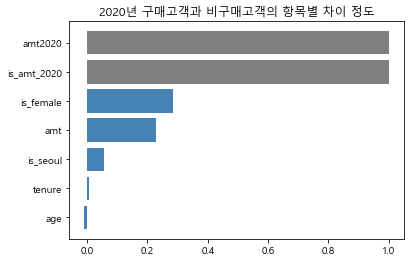

In [59]:
# 프로파일 테이블의 시각화

# 차이가 큰 변수 순으로 정렬
cust_prfl5s1 = cust_prfl5s1.sort_values('r0', ascending=False)

colors1 = np.where(cust_prfl5s1.index.isin(['amt2020', 'is_amt_2020']), 'grey', 'steelblue')
plt.barh(cust_prfl5s1.index, 1-cust_prfl5s1.r0, 
         color=colors1)
plt.title('2020년 구매고객과 비구매고객의 항목별 차이 정도')

[주의] 각 X 항목과 Y를 1:1로 비교하는 프로파일링은 유용성 제한적 (이해를 돕기위한 보조 수단)
- X의 각 항목들간에 상관관계가 존재할 수 있음 고려 필요
    

# 추가 연습문제

- **주말**에 구매가 많은 고객들의 특성을 트리 모델을 사용해 분석하라
<br><br>
- 2020년 **구매일수**가 많은 고객들의 특성을 기본정보와 2019년 행동 패턴, **점포와 브랜드별** 이용패턴까지 활용해서 분석하라
<br><br>
- 2020년 1, 2, 3월 데이터만 사용하여 그 **다음 달인 2020년 4월의 구매일수** 패턴을 고객별로 분석하라 (트리 모델과 프로파일링 모두 활용)